In [1]:
import numpy as np
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from transformers import TimeSeriesTransformerForPrediction
from forecast_test import TimeSeriesDataset
from tqdm import tqdm
from torch.utils.data import Dataset

In [2]:
print("Loading model...")
model = TimeSeriesTransformerForPrediction.from_pretrained("./forecast_exp/target30").to("cuda")
model.eval()

# Load validation data
print("Loading data...")
data = np.load("data/trajectories.npy")
train_size = int(0.8 * data.shape[0])
val_data_indices = np.arange(train_size, data.shape[0])
INPUT_LENGTH = 80
TARGET_LENGTH = 30
data = data.transpose(1,0,2)

Loading model...
Loading data...


In [ ]:
with torch.no_grad():
    forecasts = []
    actuals = []
    keep_until = 5
    for idx in tqdm(val_data_indices):
        # use past observed values to predict future values
        past_values = torch.tensor(data[idx-INPUT_LENGTH:idx]).to("cuda")
        past_values = torch.transpose(past_values, 0, 1)[:keep_until]
        past_time_features = torch.tensor(np.arange(idx-INPUT_LENGTH, idx)).to("cuda")
        past_time_features = past_time_features.unsqueeze(1)
        future_time_features = torch.tensor([idx]).to("cuda")
        future_time_features = future_time_features.unsqueeze(1)
        past_observed_mask = torch.ones_like(past_values).to("cuda")
        # expand each tensor to have batch dimension (past_value.shape[0])
        past_time_features = past_time_features.expand(past_values.shape[0], -1, -1)
        future_time_features = future_time_features.expand(past_values.shape[0], -1, -1)
        predict = model.generate(
            past_values=past_values,
            past_time_features=past_time_features,
            future_time_features=future_time_features,
            past_observed_mask=past_observed_mask
        )
        forecasts.append(predict.sequences.cpu().numpy())
        actuals.append(data[idx])

    forecasts = np.concatenate(forecasts, axis=0)
    actuals = np.concatenate(actuals, axis=0)



In [3]:
def generate_autoregressive_predictions(
    model: torch.nn.Module,
    train_data: torch.Tensor,
    val_data: torch.Tensor,
    context_length: int = 10,
    prediction_length: int = 6,
    batch_size: int = 32,
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu'
) :
    """
    Generate autoregressive predictions for validation data using a sliding window approach.
    
    Args:
        model: Pre-trained time series transformer model
        val_data: Validation data of shape (N, T, 3)
        context_length: Length of context window used for prediction
        prediction_length: Number of steps to predict at each iteration
        batch_size: Batch size for prediction
        device: Device to run predictions on
    
    Returns:
        Tuple of (predictions, true_values)
    """
    model = model.to(device)
    model.eval()
    
    N, T, features = val_data.shape
    
    # Initialize containers for predictions and true values
    all_predictions = []
    
    # Process each sequence
    for start_idx in tqdm(range(0, N, batch_size)):
        end_idx = min(start_idx + batch_size, N)
        
        # Initialize predictions for this batch
        batch_predictions = []
        initial_context = train_data[start_idx:end_idx, -context_length:,:]
        current_input = torch.tensor(initial_context).to(device)
        
        # For each time step where we need to make predictions
        
        for t in range(0, T - prediction_length + 1, prediction_length):

            absolute_t = t + train_data.shape[1]
            # Use time indices as features
            past_time_features = torch.arange(absolute_t-context_length, absolute_t, device=device).unsqueeze(1).expand(end_idx - start_idx, context_length, 1)
            future_time_features = torch.arange(absolute_t, absolute_t + prediction_length, device=device).unsqueeze(1).expand(end_idx - start_idx, prediction_length, 1)
            
            # Generate predictions
            with torch.no_grad():
                outputs = model.generate(
                    past_values=current_input,
                    past_time_features=past_time_features.to(device),
                    future_time_features=future_time_features.to(device)
                )
            
            # Extract mean predictions (assuming model.generate returns SampleTSPredictionOutput)
            predictions = outputs.sequences.mean(dim=1)  # Average over samples
            # Update input with previous predictions
            current_input = torch.cat([
                current_input[:, prediction_length:],  # Keep later part of previous context
                predictions  # Add new predictions
            ], dim=1)

            batch_predictions.append(predictions.cpu())
            
        # Concatenate predictions for this batch
        batch_predictions = torch.cat(batch_predictions, dim=1)
        
        # Store predictions and true values
        all_predictions.append(batch_predictions)
    
    # Combine all batches
    predictions = torch.cat(all_predictions, dim=0)
    
    return predictions

def calculate_metrics(predictions: torch.Tensor, true_values: torch.Tensor) -> dict:
    """
    Calculate evaluation metrics for the predictions.
    
    Args:
        predictions: Model predictions
        true_values: Ground truth values
    
    Returns:
        Dictionary containing evaluation metrics
    """
    mse = torch.mean((predictions - true_values) ** 2).item()
    mae = torch.mean(torch.abs(predictions - true_values)).item()
    
    # Calculate feature-wise metrics
    feature_mse = torch.mean((predictions - true_values) ** 2, dim=(0, 1))
    feature_mae = torch.mean(torch.abs(predictions - true_values), dim=(0, 1))
    
    return {
        'mse': mse,
        'mae': mae,
        'rmse': np.sqrt(mse),
        'feature_mse': feature_mse.tolist(),
        'feature_mae': feature_mae.tolist()
    }

In [23]:
# Assuming you have your model, training data, and validation data ready:
model = model
train_data = data[:,:train_size]  # Shape: (N_train, T, 3)
val_data = data[:,train_size:]  # Shape: (N_val, T, 3)

# Generate predictions
# Clean CUDA memory
torch.cuda.empty_cache()
import gc
gc.collect()

predictions = generate_autoregressive_predictions(
    model=model,
    train_data=train_data,
    val_data=val_data,
    context_length=80,
    prediction_length=30,
    batch_size=512
)


  1%|          | 1/112 [00:07<13:22,  7.23s/it]

In [ ]:
np.save("forecast_results.npy", predictions)

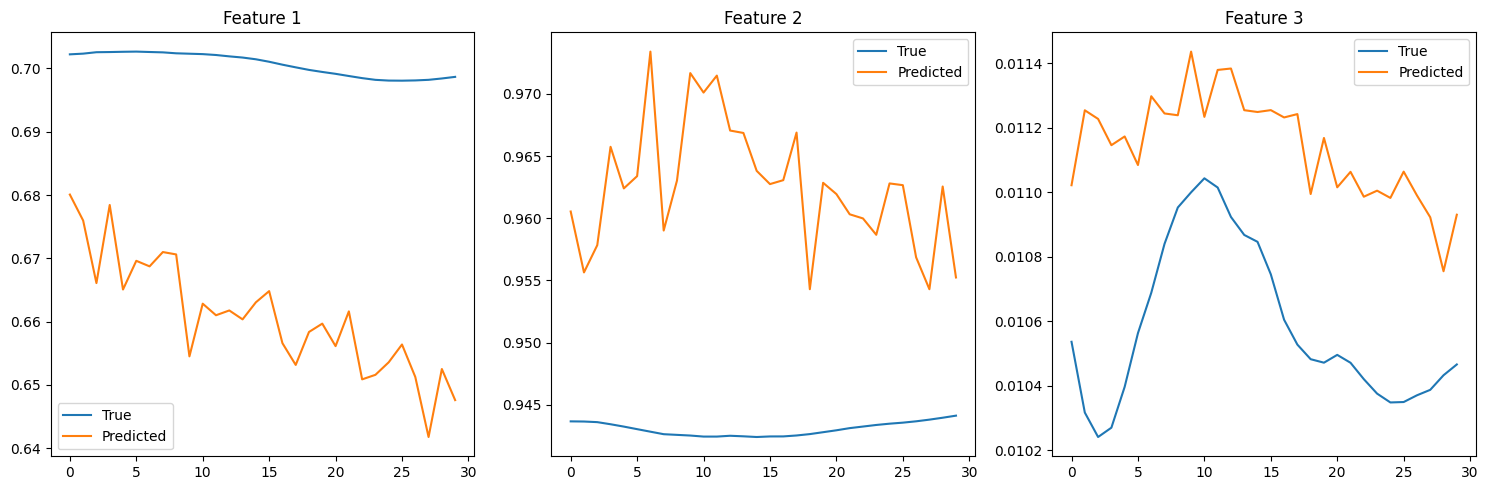

In [29]:
#predictions = predictions.cpu().numpy()
# Calculate metrics
# metrics = calculate_metrics(predictions, true_values)
# print("Evaluation metrics:", metrics)

# You can also visualize predictions for specific sequences:
sequence_idx = 20000   
plt.figure(figsize=(15, 5))
for feature_idx in range(3):
    plt.subplot(1, 3, feature_idx + 1)
    plt.plot(val_data[sequence_idx, :, feature_idx], label='True')
    plt.plot(predictions[sequence_idx, :, feature_idx], label='Predicted')
    plt.title(f'Feature {feature_idx + 1}')
    plt.legend()
plt.tight_layout()
plt.show()

In [30]:
# Assuming you have your model, training data, and validation data ready:
model = model
train_data_a = data[:,:90]  # Shape: (N_train, T, 3)
train_data_b = data[:,90:]  # Shape: (N_val, T, 3)

# Generate predictions
# Clean CUDA memory
torch.cuda.empty_cache()
import gc
gc.collect()

predictions_train = generate_autoregressive_predictions(
    model=model,
    train_data=train_data_a,
    val_data=train_data_b,
    context_length=80,
    prediction_length=30,
    batch_size=512
)

100%|██████████| 112/112 [27:00<00:00, 14.47s/it]


In [ ]:
sequence_idx = 20000   
plt.figure(figsize=(15, 5))
for feature_idx in range(3):
    plt.subplot(1, 3, feature_idx + 1)
    plt.plot(train_data_b[sequence_idx, :, feature_idx], label='True')
    plt.plot(predictions_train[sequence_idx, :, feature_idx], label='Predicted')
    plt.title(f'Feature {feature_idx + 1}')
    plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
print("Number of time features expected by model:", model.config.num_time_features)
print(model.config.num_dynamic_real_features)